# Discrete time Quantum Walk on a Line

### Implementation of quantum walk on a line with 16 nodes

In [1]:
import classiq
from classiq import *
from classiq.execution import ExecutionDetails, ExecutionPreferences, ClassiqBackendPreferences
import matplotlib.pyplot as plt
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import floor, log, pi, ceiling

size = 4  # qubits needed for storing the 16 positions


---
#### Preparing the Grover diffusion operator and the Coin operator

The Grover diffusion operator, $D= \left(2|\partial j\rangle\langle \partial j| - I\right) $, includes a step known as the **zero diffuser**. This is typically represented by the operator $2\ket{0}^{\otimes n}\bra{0}^{\otimes n} - I$, where $I$ is the identity matrix.


$$\ket{\partial j} = U \ket{0}^{\otimes n}= \frac{1}{\sqrt{\deg(j)}} \sum_{k:(j,k) \in E} |k\rangle$$

In the context of the zero diffuser, this operation reflects the amplitude of the $\ket{0}^{\otimes n}$ state while inverting the amplitude of all other states.

In [2]:
## Preparing the zero diffuser 

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):  
  aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):   
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),  
              action=lambda: diffuzer_oracle)

The coin operator $ C := \sum_j |j\rangle\langle j| \otimes \left(2|\partial j\rangle\langle \partial j| - I\right) $ is basically the application of Grover's Diffusion operator on the second set of registers, controlled by the first set of registers.

In [3]:
## Preparing the coin operator C

def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):

    # state preparation (U matrix), we assume here that at every state there is equal probability of going left/right and state 0 and state 15 are absorbing states 
    prob = [0 for j in range(2**size)]   
    if i==int(2**size - 1):
      prob[i-1]=1  #this condition is to make sure that if the walker reaches the node 15, he goes to 14 in the next step with probability 1
    elif i== 0:
      prob[i+1]=1  ##this condition is to make sure that if the walker reaches the node 0, he goes to 11 in the next step with probability 1
    else: 
      prob[i+1]=0.5  #if the walker is at any other node, there's equal chance of going right/left with equal probability 
      prob[i-1]=0.5
    
    # this part prepares the coin operator

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

In [4]:
## Perparing the S operator that swaps vertices connected by an edge 

@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

#### Implementing one step of a quantum walk

Basically application of the operator $C.S$ on an initial state $\ket{j,k}$

In [92]:
## Quantum walk implementation

@qfunc 
def main(vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  adjacent_vertices= QNum('av')
  allocate(size,adjacent_vertices)  
  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)


We use the nvidia_state_vector_simulator as the above program requires $25$ (and sometimes $26$) qubits without constraints. Execution and processing results the results can be done as follows.

max_width=25 max_depth=None max_gate_count=defaultdict(<class 'int'>, {}) optimization_parameter=<OptimizationParameter.NO_OPTIMIZATION: 'no_opt'>
Time  preprocessing=1.1163397699128836 solving=3.889027054188773 conversion_to_circuit=0.20653193490579724 postprocessing=2.8540338359307498
Width 25
***********
Opening: https://platform.classiq.io/circuit/9039ca97-c878-488f-8994-c974adc13de8?version=0.43.2


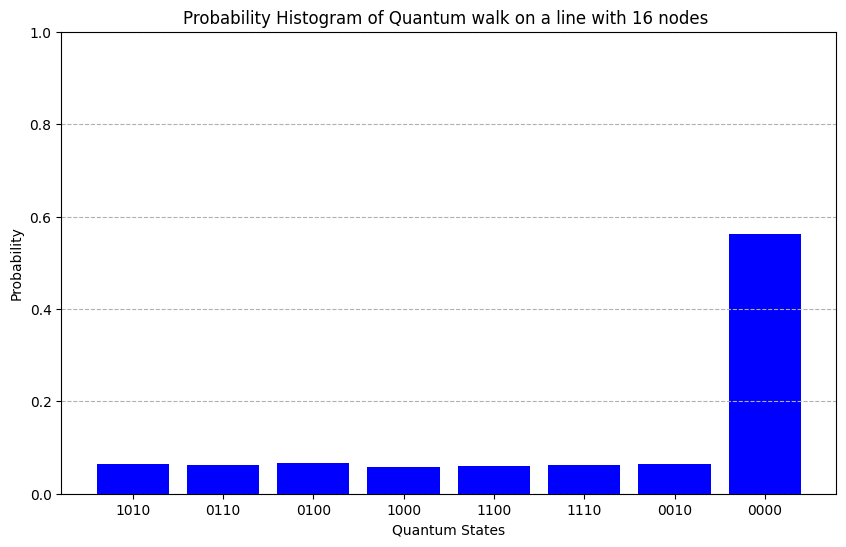

In [93]:
def run(constraints):
    qmod = create_model(main)
    if constraints is not None:
        qmod = set_constraints(qmod, constraints)
    # backend_preferences = ClassiqBackendPreferences(backend_name="nvidia_state_vector_simulator")
    # execution_preferences=ExecutionPreferences(num_shots=1000, backend_preferences=backend_preferences)
    # qmod= set_execution_preferences(qmod, execution_preferences)
    qprog = synthesize(qmod)
    print(constraints)
    print("Time ", QuantumProgram.parse_raw(qprog).synthesis_duration)
    print("Width", QuantumProgram.parse_raw(qprog).data.width)
    print("***********")
    show(qprog)
    if QuantumProgram.parse_raw(qprog).data.width<= 30:
        results = execute(qprog).result()
        dict_counts= results[0].value.counts

        # Total number of results
        total_counts = sum(dict_counts.values())

        # Calculate probabilities
        probabilities = {state: count / total_counts for state, count in dict_counts.items()}

        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(probabilities.keys(), probabilities.values(), color='blue')
        plt.xlabel('Quantum States')
        plt.ylabel('Probability')
        plt.title('Probability Histogram of Quantum walk on a line with 16 nodes ')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--')

        # Show the plot
        plt.show()

 
for c in [
    Constraints(
        max_width=25
    )
]:
    run(c)
